In [5]:
# reload

%load_ext autoreload
%autoreload 2

In [6]:
# import 

import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import time
import numpy as np
import sys

In [7]:
# redirect all print statements to file instead of console

#file_path = 'sanity_check_logs_all_runs.txt'
#sys.stdout = open(file_path, "w")

In [8]:
# list of all the file names and categories 

# All the log files from the ns-3 inbuilt RAN logs enabled by EnableTraces() 
# I have removed the Interference file because it was Goddamn huge and I did not plan on using it anyway
ran_files = ['DlTxPhyStats.txt', 'UlRxPhyStats.txt', 
             'UlSinrStats.txt', 'UlPdcpStats.txt', 'DlRsrpSinrStats.txt', 
             'UlRlcStats.txt', 'UlMacStats.txt', 'UlTxPhyStats.txt', 
             'DlPdcpStats.txt', 'DlRlcStats.txt', 'DlRxPhyStats.txt', 
             'DlMacStats.txt']

# All application related files and mobility trace that could exist
app_files = ['vrBurst_trace.txt', 'vrFragment_trace.txt', # VR
             'dashClient_trace.txt', 'mpegPlayer_trace.txt', # video streaming
             'httpServerDelay_trace.txt', 'httpClientDelay_trace.txt', 'httpClientRtt_trace.txt', # web browsing
             'dlThroughput_trace.txt', 'ulThroughput_trace.txt', # throughput measurement
             'delay_trace.txt', 'rtt_trace.txt', # delay measurement
             'flow_trace.txt'] # UDP flow 

# Other files that have connectivity and location info
other_files = ['gnb_locations.txt', 'handover_trace.txt', 'mobility_trace.txt']

# These are files that keep track of the bytes flying through the different layer.
# I am interested in this specific group to make sure that the bytes flow through 
# the layers is roughly the same after accounting for headers, and to also make sure
# that what is expected for UL and DL are satisfied. 
files_with_bytes = ['DlTxPhyStats.txt', 'DlRxPhyStats.txt',
                    'UlTxPhyStats.txt', 'UlRxPhyStats.txt',
                    'DlMacStats.txt', 'UlMacStats.txt',
                    'DlRlcStats.txt', 'UlRlcStats.txt',  
                    'DlPdcpStats.txt', 'UlPdcpStats.txt']

# Some internally generated files have a trailing tab at the end of each row, 
# but not at the end of the first header row
# This causes the read_csv function to read the data weirdly. 
# So these files have been grouped to fix that
files_with_trailing_tab=['DlRlcStats.txt', 'UlRlcStats.txt', 
                         'DlPdcpStats.txt', 'UlPdcpStats.txt']

# The timestamp unit in different RAN log files is different, even though they are all generated by the same 
# internal ns-3 logging system (eye roll)
file_name_to_tstamp_unit = {'DlTxPhyStats.txt':'ms', 'UlRxPhyStats.txt':'ms', 
                            'UlSinrStats.txt':'s', 'UlPdcpStats.txt':'s', 'DlRsrpSinrStats.txt':'s', 
                            'UlRlcStats.txt':'s', 'UlMacStats.txt':'s', 'UlTxPhyStats.txt':'ms', 
                            'DlPdcpStats.txt':'s', 'DlRlcStats.txt':'s', 'DlRxPhyStats.txt':'ms', 
                            'DlMacStats.txt':'s'}

# The internal log files do not follow a consistent naming convention for some metrics
# and hence I need to isolate them and fix it
files_that_use_upper_case_cellid=['UlPdcpStats.txt', 'UlRlcStats.txt', 'DlPdcpStats.txt', 'DlRlcStats.txt']

# columns that are not features and hence can be removed if counting number of features
nonfeature_columns = ['tstamp_us', 'ueId', 'IMSI', 'cellId', 'dir', 'pktUid']

# this is not in files so no need to remove
not_to_be_used_now=['UlInterferenceStats.txt']

In [9]:
# Which files are we actually interested in looking at 

# this has all files except interference
files = ran_files + app_files + other_files 

# This is a subset of log files that we would like to parse and plot at the moment depending on what is in the data 
files = ['rtt_trace.txt', 'delay_trace.txt',
              'gnb_locations.txt', 'handover_trace.txt', 'mobility_trace.txt']
#temp_subset = ['httpServerDelay_trace.txt'] 
#               'httpClientDelay_trace.txt', 'httpClientRtt_trace.txt']
#               'delay_trace.txt', 'rtt_trace.txt',
#               'dlThroughput_trace.txt', 'ulThroughput_trace.txt'
#               'dashClient_trace.txt', 'mpegPlayer_trace.txt']
#               'flow_trace.txt', 'mobility_trace.txt']
#               'DlTxPhyStats.txt', 'UlRxPhyStats.txt', # at enb 
#               'UlSinrStats.txt', 'UlPdcpStats.txt', 'DlRsrpSinrStats.txt', 
#               'UlRlcStats.txt', 'UlMacStats.txt', 'UlTxPhyStats.txt', 
#               'DlPdcpStats.txt', 'DlRlcStats.txt', 'DlRxPhyStats.txt', 
#               'DlMacStats.txt']

In [10]:
#=========================================
# What info / plots do you want displayed
#=========================================
print_logfile_info = True
print_byte_matrix = False
timeseries_plots = True
mobility_plots = False
histogram_plots = True
distance_plots = False

# When using time aggregation to smooth out plots and make 
# them more visually interpretable what window size to use 
time_wind_str = '500ms'
time_wind_val = 500
#===================================
# Data source
#=================================== 
data_dir = '../../data_volume/lte_3macro_30Ue_delay_rtt/'
#data_dir = '../../data_volume/lte_21macro_210Ue_delay_rtt/'
#data_dir = '../../data_volume/lte_21macro_21Ue_delay_rtt_1Ue_dlThput/'
#data_dir = '../../data_volume/lte_21macro_21Ue_delay_rtt_1Ue_ulThput/'

# Specify here topology details from the dataset we are using 
# This can be infered from the files, but this is easier 
total_num_cells=3
total_num_ues=30
num_runs = 10
sim_time = 1000 # seconds
sim_start_time = pd.to_datetime(0, unit='s', origin='unix')
sim_end_time = pd.to_datetime(sim_time, unit='s', origin='unix')

dict_gnb_pos = pd.read_csv(data_dir+'run1/gnb_locations.txt', sep=',')
dict_gnb_pos = dict_gnb_pos.set_index('cellId')
dict_gnb_pos = dict_gnb_pos.to_dict('index')
#{
#1: {'gnbpos_x': 1, 'gnbpos_y': 0.5, 'gnbpos_z' : 0.5}, 
#2: {'gnbpos_x': 1, 'gnbpos_y': 0.5, 'gnbpos_z' : 0.5},
#3: {'gnbpos_x': 1, 'gnbpos_y': 0.5, 'gnbpos_z' : 0.5}
#}

In [11]:
#=======================================
# Sanity checks that this script runs 
#=======================================

# (done) Runtime: Did all logs for all runs generate data for the entire simulation duration (prints)

# (done) IDs: ue_id / cell_id presence in logs. Does each log have representation from
#      all the UEs and cells that should be present (prints)

# (done) Delay histograms: Are there any ridiculously large delays in the data that cannot be explained. 
#                   (delay, rtt trace histograms combined for all UEs)

# (done) Thput histograms: Understand the throuphput variability caused by only signal variations and not user contention  
#                   ul/dl histograms combined for all UEs  

# (done) Byte Matrix: Are the number of bits going over the network at the different layers similar ? : (byte matrix)
#              Is the traffic UL and DL as expected based on the traffic being sent. 
#              Is it symetric when there is no one way traffric ? : (byte matrix)

# (done) Mobility plot: Plot the movement of the UEs and make sure they make sense (In another script)

# (done) Delay probe delivery rate: Combined for all UEs to check how droppy this network is
# (done) Average throughput over the entire region (all UEs, all cells, entire area)  
# (done) Number of handovers per unit time per unit cell
# (done) Average/histogram time between HO for a slow moving UE and a fast moving UE

# plot per cell timeseries of DL traffic aggrergated over windows
# plot per UE time series of DL SINR/RSRP separately for a sample fast and slow moving UE   

# (done) Plot distance to BS versus delay/rtt: combined for all UEs
# (done) Plot distance to BS versus ul/dl throughput: combined for all UEs
# (done) Plot distance to BS versus signal strength: combined for all UEs (rsrp, ul sinr, dl sinr) NOTE: power control is being used 

# Application metrics aggregated over all UEs running this app to plot histograms 
# page_load_time histogram: page load time over all webpages viewed 
# segment_bitrate histogram: bitrate of segment requested over all videos watched
# vr_burst_time histogram: time to receive a full burst in VR

In [12]:
#=======================================
# Organising UEs into groups 
#=======================================

# Slow moving UEs group 
# Fast moving UEs group 
# Web browsing UEs group 
# Video streaming UEs group 
# VR UEs group 
# No traffic apps UEs group 
# Thput measurement UE 

# based on the UE entries in the corresponding log files I can get the UE IMSIs of app groups  
# it is only slow moving and fast moving UE categories that I cannot separate out from files 
# (easily at least, I could measure the average speed and categorize them)


# Separate out the IDs of the UEs that have a specific set of apps running on them  
#ueIds = np.arange(0,total_num_ues)
# UEs with only delay measurements and no background traffic:
#isIncluded=np.array( [((x % 5) == 0) for x in range(0,total_num_ues)], dtype=bool)
#trafficClass1_ueIds=ueIds[isIncluded]
# UEs with video streams:
#isIncluded=np.array( [ ( ((x % 5) != 0) and (x%2 ==0) ) for x in range(0,total_num_ues)], dtype=bool)
#trafficClass2_ueIds=ueIds[isIncluded]
# UEs with web browsing:
#isIncluded=np.array( [ ( ((x % 5) != 0) and (x%2 !=0) ) for x in range(0,total_num_ues)], dtype=bool)
#trafficClass3_ueIds=ueIds[isIncluded]

#!!!!!! But I do not know what the IMSI of these ueIds are 
#Maybe I should create these groups in ns3 code using IMSI instead of ueId 

In [13]:
#=======================================
# Initilizing empty lists 
#=======================================

# To measure delay probe delivery rate 
ul_delay_probe_delivery_rate = 0
dl_delay_probe_delivery_rate = 0
rtt_probe_delivery_rate = 0
ul_avg_thput = 0
dl_avg_thput = 0

# Baselines for empty networks
# Aggregate over UEs and runs for histogram plots
ul_delays = np.empty(0)
dl_delays = np.empty(0)
rtt_delays = np.empty(0)
ul_thput = np.empty(0)
dl_thput = np.empty(0)

# Baselines for empty networks
# distance to BS versus metrics, aggregated over windows 
w_dist_to_cell = np.empty(0)
w_ul_delay = np.empty(0)
w_dl_delay = np.empty(0)
w_rtt_delay = np.empty(0)
w_ul_sinrLinear = np.empty(0)
w_dl_sinr = np.empty(0)
w_rsrp = np.empty(0)


# app specific observations for plotting
# aggregated over all UEs running this app to plot histograms 
page_load_time = np.empty(0) # page load time over all webpages viewed 
segment_bitrate = np.empty(0) # bitrate of segment requested over all videos watched
vr_burst_time = np.empty(0) # time to receive a full burst in VR 

# handover related initializers
hos_per_cell_per_time = 0
time_bw_hos = np.empty(0) # seconds 


# constant multipliers
M = (10**6)
K = (10**3)


../../data_volume/lte_3macro_30Ue_delay_rtt/run3
--------------------------------------------
rtt_trace.txt
time to read file:  0.15772438049316406
log time (start, end): ( 5.23999e-07 ,  0.001000903999 )
log runtime: 1000.38  seconds
Sum of RTT probes for all UEs:  267189


/home/ubuntu/miniconda3/envs/data-process/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


--------------------------------------------
delay_trace.txt
time to read file:  0.3079342842102051
log time (start, end): ( 5.33999e-07 ,  0.0010010479309999999 )
log runtime: 1000.513932  seconds
Sum of Delay probes for all UEs: UL:  263481  DL:  299675


AttributeError: 'str' object has no attribute 'plot'

<Figure size 432x288 with 0 Axes>

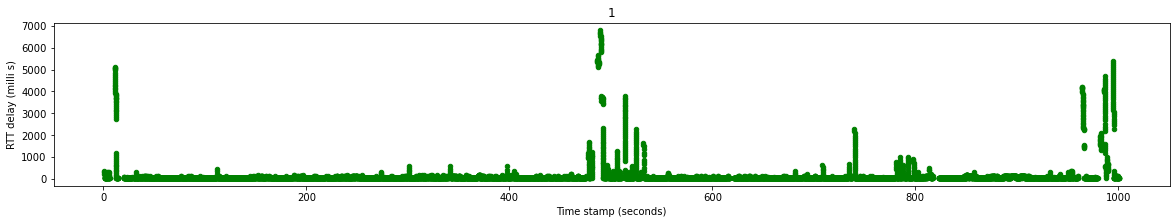

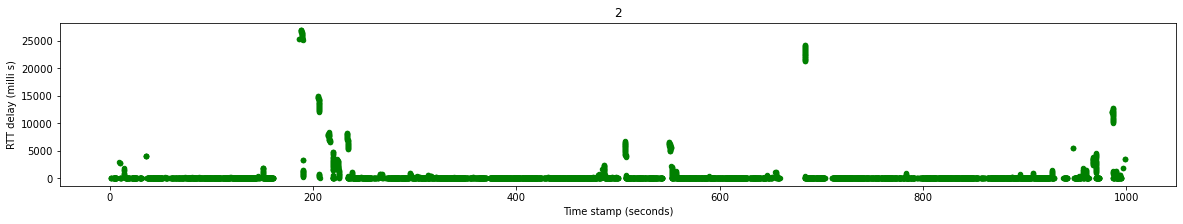

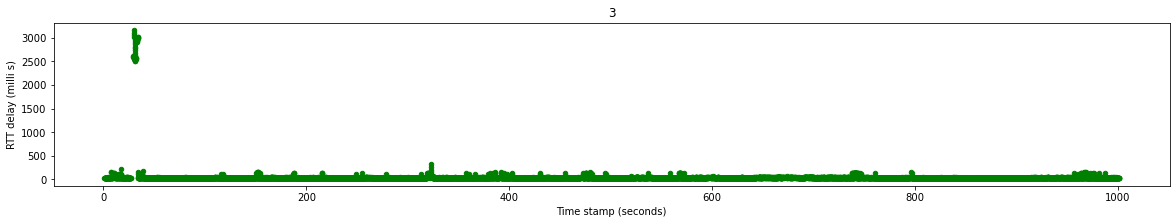

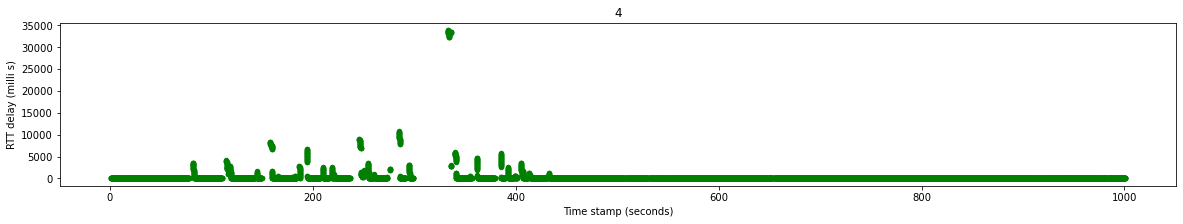

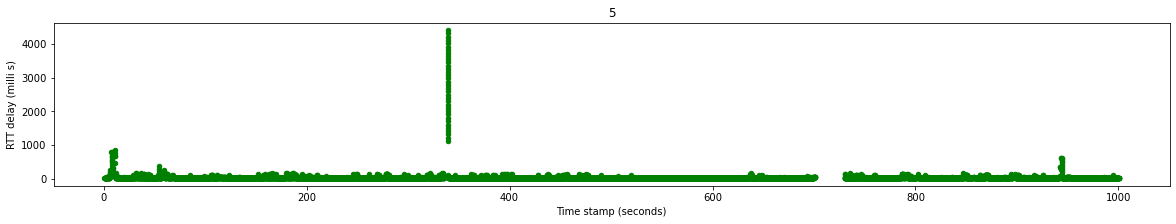

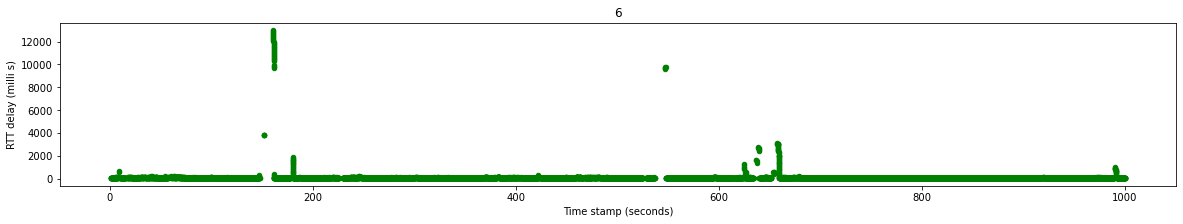

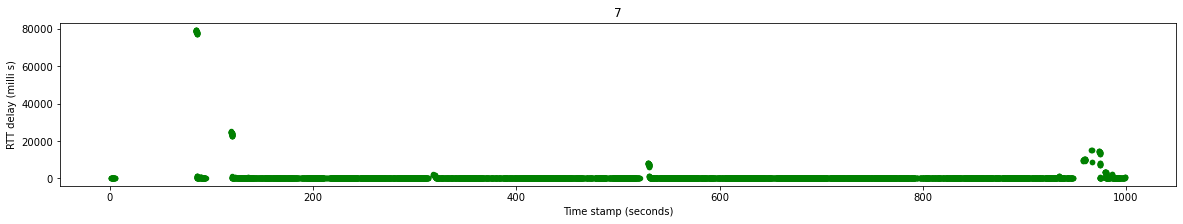

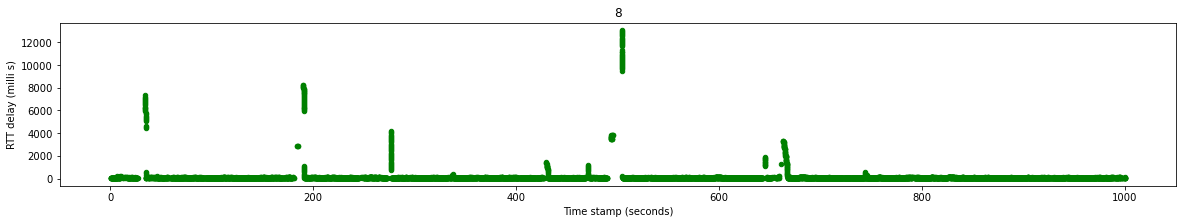

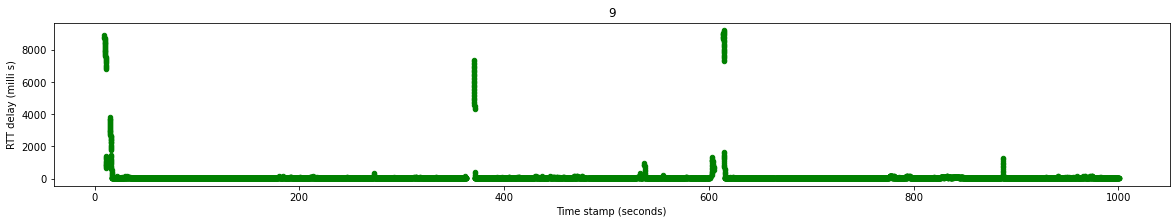

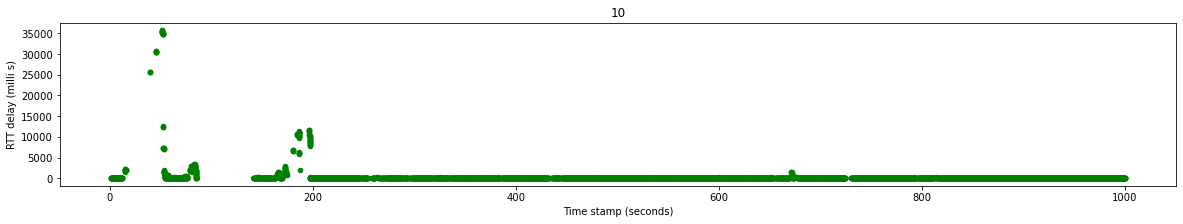

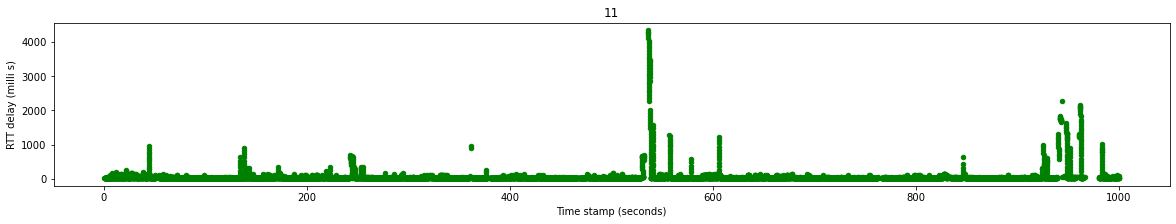

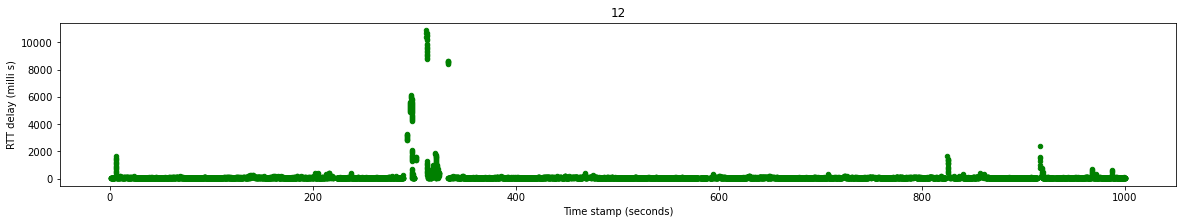

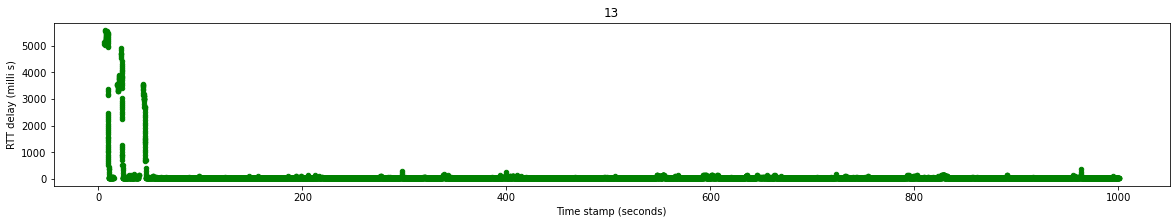

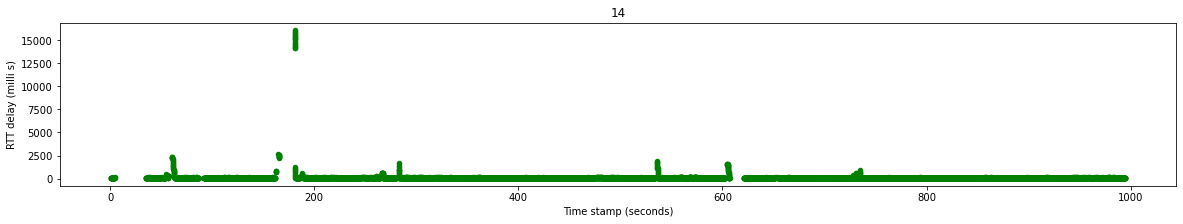

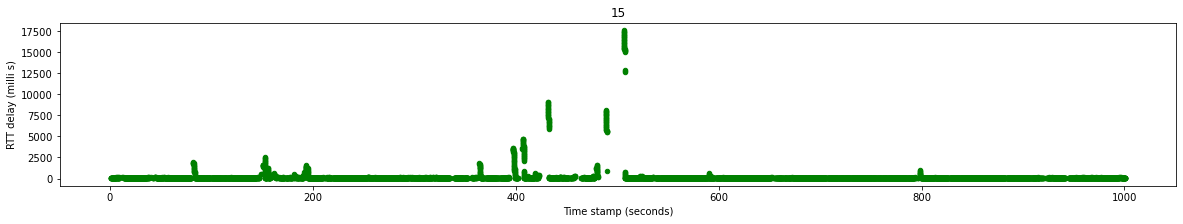

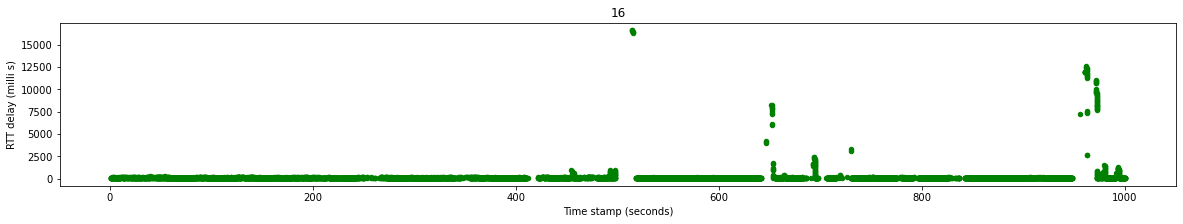

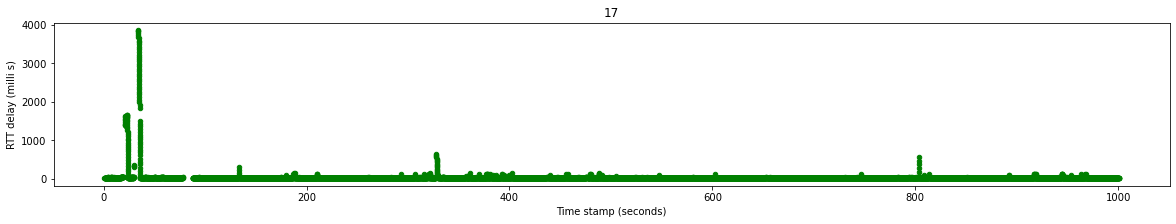

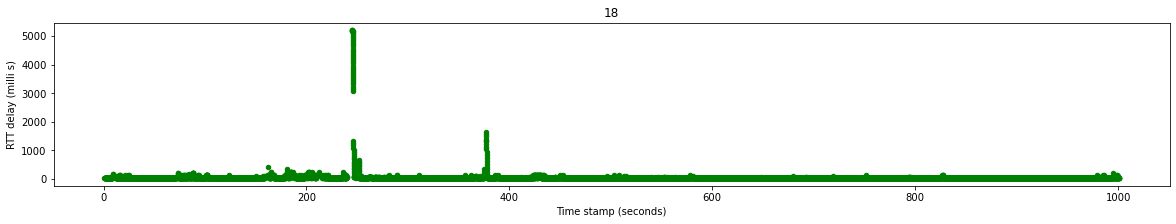

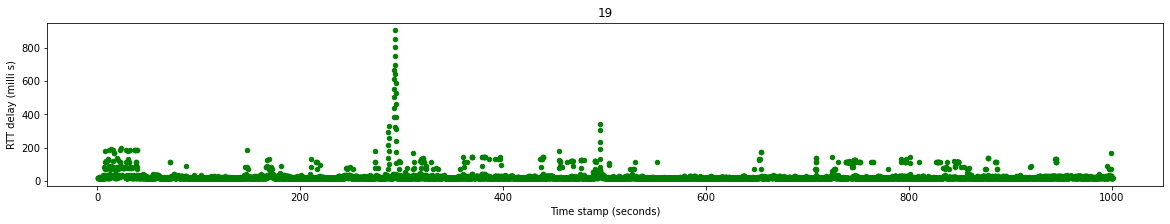

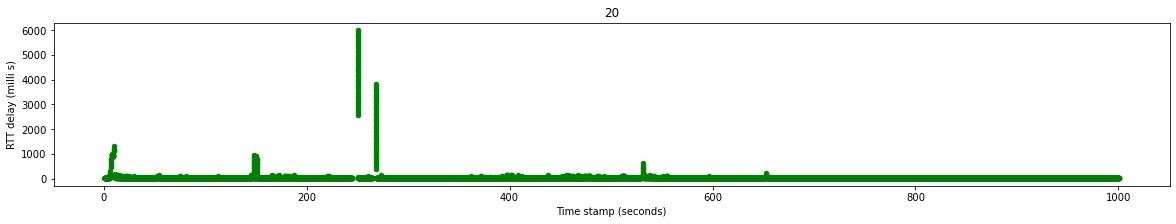

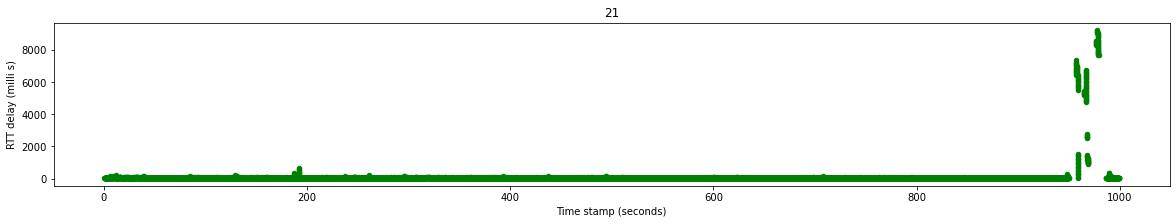

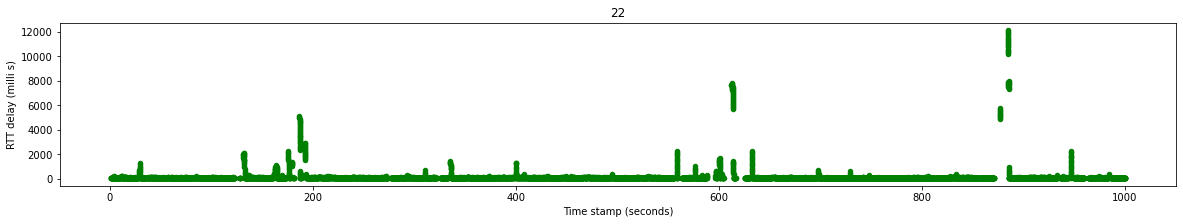

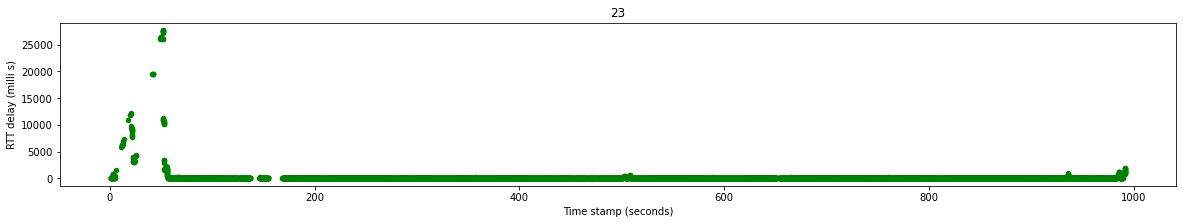

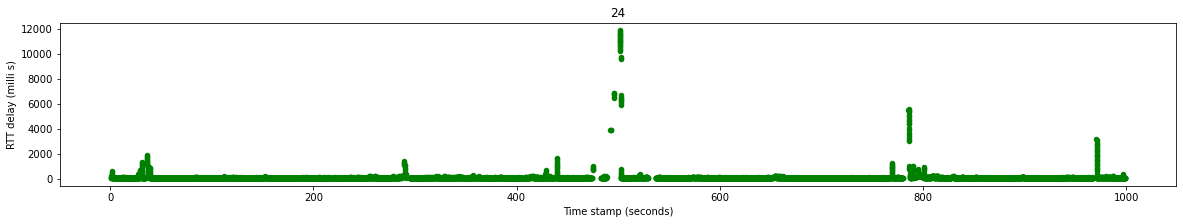

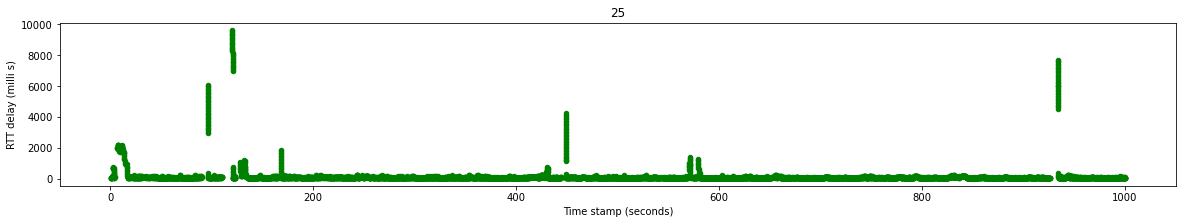

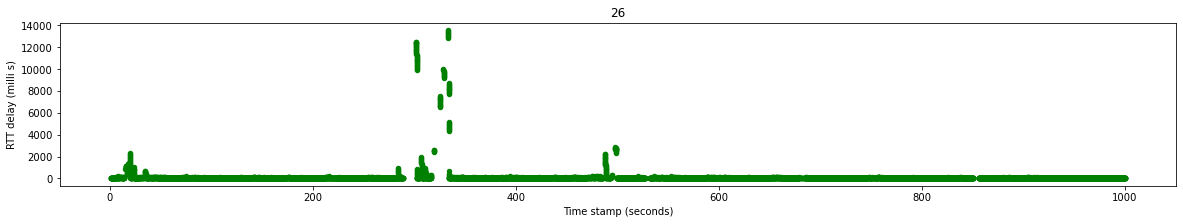

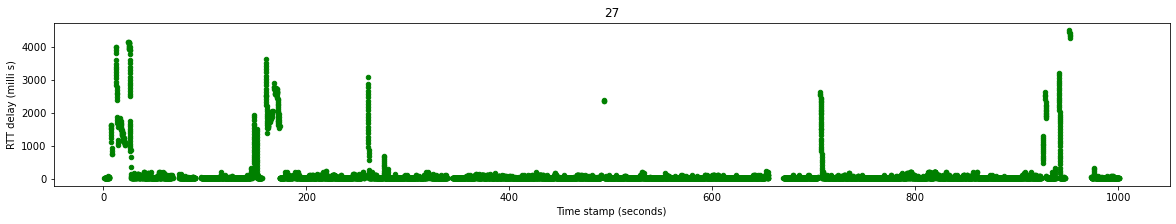

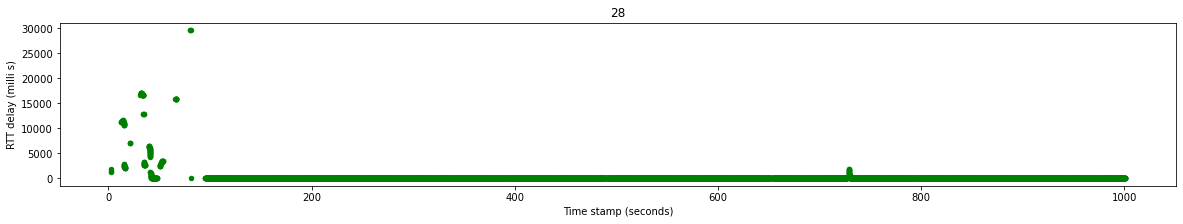

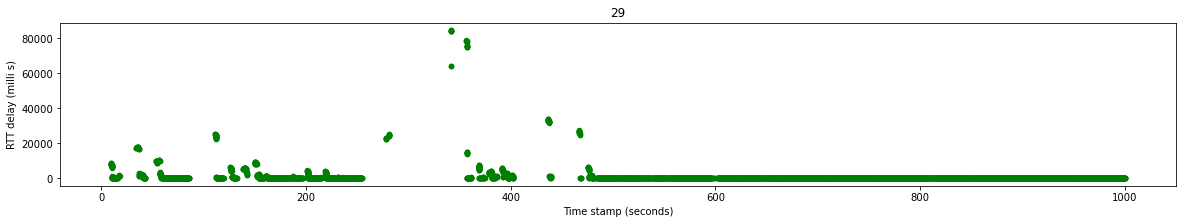

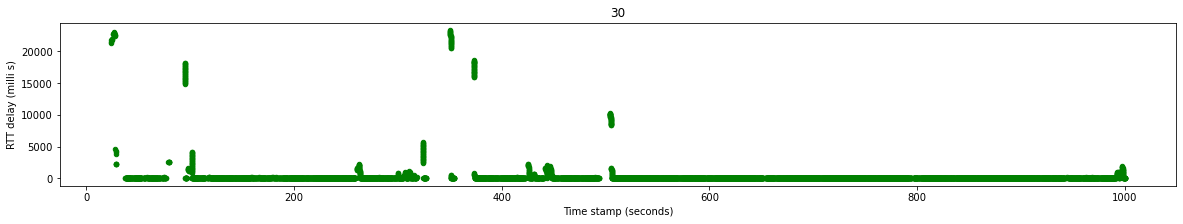

<Figure size 432x288 with 0 Axes>

In [14]:
#=======================================
# Iterate over runs and files 
#=======================================


#=================================================================
#for run in os.listdir(data_dir):
for run in glob.glob(data_dir+'run*'):
#for run in ['run1']:
#=================================================================

    print('============================================================')
    print (run)
    print('============================================================')
    # To store and compare the number of bytes sent and received in different RAN layers 
    bytes_matrix = np.zeros((4, 4), dtype=int)
    
    ## Iterate over log files in each run
    ## Use temp_subset instead of files if I only want to investigate a subset for now
    ax = [None] * total_num_ues
    
#=================================================================
    for file in files:
#=================================================================
        print('--------------------------------------------')
        print(file)
        start_time = time.time()
        
        #=======================================
        # Preprocess logs 
        #=======================================
        
        ## Read file while fixing the tab issue
        if file in files_with_trailing_tab:
            df = pd.read_csv(data_dir+run+'/'+file, sep='\t', usecols=range(0,18))
        else:
            df = pd.read_csv(data_dir+run+'/'+file, sep='\t')
        
        print('time to read file: ', (time.time() - start_time))
        
        ## Do some file specific preprocessing
        ## Make uniform the timestamp units convert them all to micro seconds 
        if '% time' in df.columns:
            df.rename(columns = {'% time':'tstamp_us'}, inplace = True)
            if file_name_to_tstamp_unit[file] == 'ms':
                df['tstamp_us'] = df['tstamp_us']*K
            elif file_name_to_tstamp_unit[file] == 's':
                df['tstamp_us'] = df['tstamp_us']*M
        ## Make uniform the timestamp units        
        if '% start' in df.columns:
            ## TO DO: check if this is actually micro seconds. I think it is seconds   
            df.rename(columns = {'% start':'tstamp_us'}, inplace = True)
            df.rename(columns = {'end':'end_timeslot_us'}, inplace = True)
            df['tstamp_us'] = df['tstamp_us']*M
            df['end_timeslot_us'] = df['end_timeslot_us']*M
        ## Some internally generated logs use the naming 'CellId' replace that with 'cellId'
        if 'CellId' in df.columns:
            df.rename(columns = {'CellId':'cellId'}, inplace = True)
        
        ## Just for plotting change the timestamp_us to seconds and delay values to milli seconds 
        ## since I am mostly plotting directly from pandas and don't know how to add a multiplicative factor to a column 
        df['tstamp_us'] = df['tstamp_us']/M
        # converting all delay values to ms instead of us
        if 'delay' in df.columns:
            df['delay'] = df['delay']/K
        # Warning: cellId and IMSI here are IP addresses, but it should not matter since 
        # there will only be 1 UE doing these ul and dl throughput scans   
        if 'dlThroughput_trace.txt':
            df.rename(columns = {'toAddr':'IMSI', 'fromAddr': 'cellId'}, inplace = True)
        if 'ulThroughput_trace.txt':
            df.rename(columns = {'toAddr':'cellId', 'fromAddr': 'IMSI'}, inplace = True)
        # Set datetime index for all files so that we can do series operations 
        datatime_timestamps = pd.to_datetime(df['tstamp_us'], unit='s', origin='unix')
        df.set_index(datatime_timestamps, inplace=False)
        # if the above gives as error then use
        #df['tstamp_us'] = pd.to_datetime(df['tstamp_us'], unit='s', origin='unix')
        #df.set_index('tstamp_us', inplace=False)
        
        
        #=======================================
        # Print log file info  
        #=======================================
        if print_logfile_info:
            ## Display info about the UEs who have made entries in this file to make sure that all the UEs who should be here are here. 
            print('ueIds: min:', min(df['IMSI'].value_counts().index), 'max:', max(df['IMSI'].value_counts().index),
                 'count:', len(df['IMSI'].value_counts().index))

            ## Display info about the Cells who have made entries in this file
            print('cellIds: min:', min(df['cellId'].value_counts().index), 'max:', max(df['cellId'].value_counts().index),
                 'count:', len(df['cellId'].value_counts().index))

            ## Total runtime of log
            print('log time (start, end): (', df['tstamp_us'].iloc[0], ', ' ,df['tstamp_us'].iloc[-1], ')')
            print('log runtime:', (df['tstamp_us'].iloc[-1] - df['tstamp_us'].iloc[0]), ' seconds')
        
        
        #=======================================
        # Byte matrix: Aggregate bytes over runs  
        #=======================================
        
        ## Gather the number of bytes sent from/to all UEs in each layer and direction to compare
        if file == 'DlTxPhyStats.txt':
            bytes_matrix[0,0] = df['size'].sum()/M
        elif file == 'DlRxPhyStats.txt':
            bytes_matrix[2,0] = df['size'].sum()/M
        elif file == 'UlTxPhyStats.txt':
            bytes_matrix[1,0] = df['size'].sum()/M
        elif file == 'UlRxPhyStats.txt':
            bytes_matrix[3,0] = df['size'].sum()/M
        elif file == 'DlMacStats.txt':
            bytes_matrix[0,1] = (df['sizeTb1'].sum() + df['sizeTb2'].sum())/M
        elif file == 'UlMacStats.txt':
            bytes_matrix[1,1] = df['size'].sum()/M
        elif file == 'DlRlcStats.txt':
            bytes_matrix[0,2] = df['TxBytes'].sum()/M
            bytes_matrix[2,2] = df['RxBytes'].sum()/M
        elif file == 'UlRlcStats.txt':
            bytes_matrix[1,2] = df['TxBytes'].sum()/M
            bytes_matrix[3,2] = df['RxBytes'].sum()/M
        elif file == 'DlPdcpStats.txt':
            bytes_matrix[0,3] = df['TxBytes'].sum()/M
            bytes_matrix[2,3] = df['RxBytes'].sum()/M
        elif file == 'UlPdcpStats.txt':
            bytes_matrix[1,3] = df['TxBytes'].sum()/M
            bytes_matrix[3,3] = df['RxBytes'].sum()/M
    
        ## Group by UE
        #if file == 'dashClient_trace.txt':
            #print(    df.groupby(by=['IMSI'])['segmentId'].size()    )   # count   
            #print(    (df.groupby(by=['IMSI'])['segmentId'].max() - df.groupby(by=['IMSI'])['segmentId'].min() + 1)   )   # expected count
        # this means there are no in between missing logs, they are just not going beyond a certain point and stopping 
        # at different times for each UE and at different times in each run. 

        if file == 'DlRsrpSinrStats.txt':
            w_rsrp = np.append(w_rsrp, 
                                    df.sort_values(by=['IMSI']).groupby(by=['IMSI']).resample(time_wind_str).mean()['rsrp'][start_sim_time : end_sim_time].reset_index(level='IMSI'))
            w_dl_sinr = np.append(w_dl_sinr, 
                                    df.sort_values(by=['IMSI']).groupby(by=['IMSI']).resample(time_wind_str).mean()['sinr'][start_sim_time : end_sim_time].reset_index(level='IMSI'))
          
        if file == 'UlSinrStats.txt':
            # note that the UL sinr is linear while the dl sinr is in dB (I think ... )
            w_ul_sinrLinear = np.append(w_ul_sinrLinear, 
                                    df.sort_values(by=['IMSI']).groupby(by=['IMSI']).resample(time_wind_str).mean()['sinrLinear'][start_sim_time : end_sim_time].reset_index(level='IMSI'))
            
        if file == 'delay_trace.txt':
            # separate UL and DL 
            ul_probes = df.groupby(by=['dir']).get_group('UL').groupby(by=['IMSI']).size()
            dl_probes = df.groupby(by=['dir']).get_group('DL').groupby(by=['IMSI']).size()
            # group by UE
            #print('UL # delay probes per UE: ', ul_probes)
            #print('DL # delay probes per UE: ', dl_probes)
            print('Sum of Delay probes for all UEs: UL: ', ul_probes.sum(), ' DL: ', dl_probes.sum())
            ul_delay_probe_delivery_rate = ul_delay_probe_delivery_rate + ul_probes.sum()
            dl_delay_probe_delivery_rate = dl_delay_probe_delivery_rate + dl_probes.sum()
            # for histogram
            ul_delays = np.append(ul_delays, df.groupby(by=['dir']).get_group('UL')['delay'])
            dl_delays = np.append(dl_delays, df.groupby(by=['dir']).get_group('DL')['delay'])
            
            # need to organize by UE IMSI 
            w_ul_delays = np.append(w_ul_delays, 
                                    df.groupby(by=['dir'], as_index=False).get_group('UL').sort_values(by=['IMSI']).groupby(by=['IMSI']).resample(time_wind_str).mean()['delay'][start_sim_time : end_sim_time].reset_index(level='IMSI'))
            w_dl_delays = np.append(w_dl_delays, 
                                    df.groupby(by=['dir'], as_index=False).get_group('DL').sort_values(by=['IMSI']).groupby(by=['IMSI']).resample(time_wind_str).mean()['delay'][start_sim_time : end_sim_time].reset_index(level='IMSI'))
            
        if file == 'rtt_trace.txt':
            rtt_probes = df.groupby(by=['IMSI']).size()
            # group by UE
            #print('# RTT probes per UE: ', rtt_probes)
            print('Sum of RTT probes for all UEs: ', rtt_probes.sum())
            rtt_probe_delivery_rate = rtt_probe_delivery_rate + rtt_probes.sum()
            # for histogram
            rtt_delays = np.append(rtt_delays, df['delay'])
            w_rtt_delays = np.append(w_rtt_delays, 
                                    df.sort_values(by=['IMSI']).groupby(by=['IMSI']).resample(time_wind_str).mean()['delay'][start_sim_time : end_sim_time].reset_index(level='IMSI'))
            
        if file == 'ulThroughput_trace.txt':
            ul_avg_thput = ul_avg_thput + (df['pktSize'].sum()/M) # MB
            assert (df['IMSI'].nunique() == 1), "More than one throughput measurement UE is in the logs" 
            # even the mobility log should only have one UE or we wont know which one to match with this log for distance versus metric graphs 
            ul_thput = np.append(ul_thput, df['pktSize'].resample(time_wind_str).sum()*8/(time_wind_val*K)[start_sim_time : end_sim_time])# Mbps
            
        if file == 'dlThroughput_trace.txt':
            dl_avg_thput = dl_avg_thput + (df['pktSize'].sum()/M) # MB
            assert (df['IMSI'].nunique() == 1), "More than one throughput measurement UE is in the logs" 
            # even the mobility log should only have one UE or we wont know which one to match with this log for distance versus metric graphs
            dl_thput = np.append(dl_thput, df['pktSize'].resample(time_wind_str).sum()*8/(time_wind_val*K)[start_sim_time : end_sim_time])# Mbps   
        
        if file == 'handover_trace.txt':
            hos_per_cell_per_time = hos_per_cell_per_time + df.shape[0]
            time_bw_hos = np.append(time_bw_hos, df['tstamp_us'].diff().drop(index=df.index[0], axis=0, inplace=True))        
        
        if file == 'mobility_trace.txt':
            # add a distance column which is the distance from the UE to the cell it is connected to 
            ue_pos = df['pos_x', 'pos_y'].values() 
            gnb_pos = [dict_gnb_pos[cellId] for cellId in df['cellId'].values()]
            distance = [math.dist([gnb_loc['gnbpos_x'],gnb_loc['gnbpos_x']], ueloc) for gnb_loc,ue_loc in zip(gnb_pos,ue_pos)]          
            # gnb_pos is a list of dictionaries as well with keys {'gnbpos_x': 1, 'gnbpos_y': 0.5, 'gnbpos_z' : 0.5}
            # so it is a list of dictionaries 
            # Does it have 0 IMSI values ? if so then I need to remove it  
            # add distance as a column 
            df['dist_to_cell'] = distance
            w_dist_to_cell = np.append(w_dist_to_cell, 
                                      df.sort_values(by=['IMSI']).groupby(by=['IMSI']).resample(time_wind_str).mean()['dist_to_cell'][start_sim_time : end_sim_time].reset_index(level='IMSI')))
                     
        #if file == 'flow_trace.txt':
        #    # separate UL and DL 
        #    ul_brate = df.groupby(by=['dir']).get_group('UL').groupby(by=['IMSI'])['pktSize'].sum()/(M) # MB
        #    ul_brate = ul_brate*8/(df['tstamp_us'].iloc[-1] - df['tstamp_us'].iloc[0]) 
        #    dl_brate = df.groupby(by=['dir']).get_group('DL').groupby(by=['IMSI'])['pktSize'].sum()/(M) # MB
        #    dl_brate = dl_brate*8/(df['tstamp_us'].iloc[-1] - df['tstamp_us'].iloc[0]) 
        #    # group by UE
        #    print('UL brate Mbps per UE: ', ul_brate)
        #    print('DL brate Mbps per UE: ', dl_brate)
        #    #print('UL Giga Bytes sent by each UE over the duration of the simulation: ', ul_bytes_sent)
        #    #print('DL Giga Bytes sent by each UE over the duration of the simulation: ', dl_bytes_sent)
        
        #=======================================
        # Plot timeseries   
        #=======================================
        
        if timeseries_plots:       
                       
            ## RAN plots
            if file == 'UlSinrStats.txt':
                ## Group by UE 
                ## Time series plot
                df_grouped = df.groupby(by=['IMSI'])
                for name, df_ue in df_grouped:
                    ## temp
                    #if (name == 1) or (name == 3):
                    df_ue['sinrLinear'] = 10*np.log10(df_ue['sinrLinear'])
                    plt.figure(name)
                    ax[name-1] = df_ue.plot(x='tstamp_us', y='sinrLinear', sharey=True,
                                               ylabel='UL SINR (dB)', xlabel='Time stamp (seconds)', title=name,
                                               figsize=(20,3), color='cyan', kind='scatter', ax=ax[name-1])
                
            
            if file == 'DlRsrpSinrStats.txt':
                ## Group by UE 
                ## Time series plot
                df_grouped = df.groupby(by=['IMSI'])
                for name, df_ue in df_grouped:
                    ## temp
                    #if (name == 1) or (name == 3):
                    plt.figure(name)
                    ax[name-1] = df_ue.plot(x='tstamp_us', y='cellId', sharey=True,
                                               ylabel='CellId', xlabel='Time stamp (seconds)', title=name,
                                               figsize=(20,3), color='red', kind='scatter', ax=ax[name-1])
                    #df_ue.plot(x='tstamp_us', y='rsrp', subplots=True,
                    #                           ylabel='RSRP', xlabel='Time stamp (seconds)', title=name,
                    #                           figsize=(20,3), color='pink', kind='scatter')
                
            if file == 'DlMacStats.txt':
               ## Group by UE 
                ## Time series plot
                df_grouped = df.groupby(by=['IMSI'])
                for name, df_ue in df_grouped:
                    ## temp
                    #if (name == 1) or (name == 3):
                    plt.figure(name)
                    ax[name-1] = df_ue.plot(x='tstamp_us', y='mcsTb1', 
                                               ylabel='MCS', xlabel='Time stamp (seconds)', title=name,
                                               figsize=(20,3), color='blue', kind='scatter', ax=ax[name-1])
            if file == 'UlMacStats.txt':
                ## Group by UE 
                    ## Time series plot
                    df_grouped = df.groupby(by=['IMSI'])
                    for name, df_ue in df_grouped:
                        ## temp
                        #if (name == 1) or (name == 3):
                        plt.figure(name)
                        ax[name-1] = df_ue.plot(x='tstamp_us', y='mcs', 
                                                   ylabel='MCS', xlabel='Time stamp (seconds)', title=name,
                                                   figsize=(20,3), color='green', kind='scatter', ax=ax[name-1])
            
            
            ## OWD plots 
            if file == 'delay_trace.txt': 
                ## Group by UE per direction 
                df_ul = df.groupby(by=['dir']).get_group('UL').groupby(by=['IMSI']).agg(['count'])
                df_dl = df.groupby(by=['dir']).get_group('DL').groupby(by=['IMSI']).agg(['count'])
                ## Time series plot
                for name, df_ue in df_ul:
                    #if (name == 1) or (name == 3):
                    plt.figure(name)
                    ax[name-1] = df_ue.plot(x='tstamp_us', y='delay', xlabel='Time stamp (seconds)', ylabel='UL delay (milli s)', title=name, 
                                             figsize=(20,3), color='magenta', kind='scatter', ax=ax[name-1])
                    
                for name, df_ue in df_dl:
                    #if (name == 1) or (name == 3):
                    plt.figure(name)
                    ax[name-1] = df_ue.plot(x='tstamp_us', y='delay', xlabel='Time stamp (seconds)', ylabel='DL delay (milli s)', title=name, 
                                             figsize=(20,3), color='gold', kind='scatter', ax=ax[name-1])

            ## RTT plots
            elif file == 'rtt_trace.txt':
                ## Group by UE 
                ## Time series plot
                df_grouped = df.groupby(by=['IMSI'])
                for name, df_ue in df_grouped:
                    ## temp
                    #if (name == 1) or (name == 3):
                    plt.figure(name)
                    ax[name-1] = df_ue.plot(x='tstamp_us', y='delay', 
                                               ylabel='RTT delay (milli s)', xlabel='Time stamp (seconds)', title=name,
                                               figsize=(20,3), color='green', kind='scatter', ax=ax[name-1])

            ## Browsing: Time between object request and object download (confirm this from the ns3 model) 
            elif file == 'httpClientRtt_trace.txt':
                ## Group by UE
                ## Time series plot
                df_grouped = df.groupby(by=['IMSI'])
                for name, df_ue in df_grouped:
                    plt.figure(name)
                    ax[name-1] = df_ue.plot(x='tstamp_us', y='delay', 
                                               ylabel='http object RTT (milli s)', xlabel='Time stamp (seconds)', title=name,
                                               figsize=(20,3), color='magenta', kind='scatter', ax=ax[name-1])

            ## Browsing: Time to download object (confirm this from the ns3 model)
            elif file == 'httpClientDelay_trace.txt':
                df_grouped = df.groupby(by=['IMSI'])
                for name, df_ue in df_grouped:
                    plt.figure(name)
                    ax[name-1] = df_ue.plot(x='tstamp_us', y='delay', 
                                               ylabel='http object delay (milli s)', xlabel='Time stamp (seconds)', title=name,
                                               figsize=(20,3), color='gold', kind='scatter', ax=ax[name-1])
        
        # end of timeseries_plots
    
    #=======================================
    # Print per run byte matrix in MB   
    #=======================================
    if print_byte_matrix:
        print ('Byte Matrix in MB')
        print('  X  phy mac rlc pdcp\n' +
              'dlTx  x   x   x   x\n' +
              'ulTx  x   x   x   x\n' +
              'dlRx  x   x   x   x\n' +
              'ulRx  x   x   x   x')
        print(bytes_matrix)

# end of for over runs
print('============================================================')


#=======================================
# Print summary statistics   
#=======================================      
ul_delay_probe_delivery_rate = ul_delay_probe_delivery_rate/(10*sim_time*total_num_ues*num_runs)  
dl_delay_probe_delivery_rate = dl_delay_probe_delivery_rate/(10*sim_time*total_num_ues*num_runs)
rtt_probe_delivery_rate = rtt_probe_delivery_rate/(10*sim_time*total_num_ues*num_runs)
print("UL delay probe delivery rate: ", ul_delay_probe_delivery_rate)
print("DL delay probe delivery rate: ", dl_delay_probe_delivery_rate)
print("RTT probe delivery rate: ", rtt_probe_delivery_rate)
print("UL survey average thoughput (Mbps): ", ul_avg_thput*8/(sim_time*num_runs))
print("DL survey average thoughput (Mbps): ", dl_avg_thput*8/(sim_time*num_runs))
print('--------------------------------------------')
print("Summary stats: ul_delays")
print(pd.Series(ul_delays).describe())
print("Summary stats: dl_delays")
print(pd.Series(dl_delays).describe())
print("Summary stats: rtt_delays")
print(pd.Series(rtt_delays).describe())
print("Summary stats: ul_thput (Mbps)")
print(pd.Series(ul_thput).describe())
print("Summary stats: dl_thput (Mbps)")
print(pd.Series(dl_thput).describe())
print("Summary stats: time bw handovers (seconds)")
print(pd.Series(time_bw_hos).describe())
print('Number of handover per cell every 100 s: ', 
      hos_per_cell_per_time*100/(total_num_cells*sim_time*num_runs))

#=======================================
# Plot histograms   
#======================================= 
if histogram_plots:
    if ('delay_trace.txt' in files):
        xlimit=500
        plt.figure(figsize=(10,3))
        plt.hist(ul_delays[ul_delays < xlimit], bins=50, color='red', edgecolor='black', label='< '+str(xlimit)+' ms')
        plt.xlabel('UL delay (ms)'); plt.xlim(0, xlimit); plt.show()
        plt.figure(figsize=(10,3))
        plt.hist(dl_delays[dl_delays < xlimit], bins=50, color='blue', edgecolor='black', label='< '+str(xlimit)+' ms') 
        plt.xlabel('DL delay (ms)'); plt.xlim(0, xlimit); plt.show()
    if ('rtt_trace.txt' in files):  
        xlimit=500
        plt.figure(figsize=(10,3))
        plt.hist(rtt_delays[rtt_delays < xlimit], bins=50, color='purple', edgecolor='black', label='< '+str(xlimit)+' ms') 
        plt.xlabel('RTT delay (ms)'); plt.xlim(0, xlimit); plt.show()       
    if ('ulThroughput_trace.txt' in files):
        plt.figure(figsize=(10,3))
        plt.hist(ul_thput, bins=50, color='red', edgecolor='black')
        plt.xlabel('UL thput (Mbps)'); plt.show()
    if ('dlThroughput_trace.txt' in files):
        plt.figure(figsize=(10,3))
        plt.hist(dl_thput, bins=50, color='blue', edgecolor='black')
        plt.xlabel('DL thput (Mbps)'); plt.show()
    if ('handover_trace.txt' in files): 
        plt.figure(figsize=(10,3))
        plt.hist(time_bw_hos, bins=50, color='green', edgecolor='black')
        plt.xlabel('Time b/w handovers (s)'); plt.show()
    
#=======================================
# Plot metrics vs UE-BS distance   
#======================================= 
if distance_plots:
    if ('delay_trace.txt' in files):
        plt.figure(figsize=(10,3))
        plt.plot(w_dist_to_cell, w_ul_delays, color='red', linestyle='None')
        plt.xlabel('Distance between UE and basestation'); plt.ylabel('UL delay (ms)'); plt.show()
        plt.figure(figsize=(10,3))
        plt.plot(w_dist_to_cell, w_dl_delays, color='blue', linestyle='None')
        plt.xlabel('Distance between UE and basestation'); plt.ylabel('DL delay (ms)'); plt.show()
    if ('rtt_trace.txt' in files):       
        plt.figure(figsize=(10,3))
        plt.plot(w_dist_to_cell, w_rtt_delays, color='purple', linestyle='None')
        plt.xlabel('Distance between UE and basestation'); plt.ylabel('RTT delay (ms)'); plt.show()
    if ('ulThroughput_trace.txt' in files):
        plt.figure(figsize=(10,3))
        plt.plot(w_dist_to_cell, ul_thput, color='red', linestyle='None')
        plt.xlabel('Distance between UE and basestation'); plt.ylabel('UL throughput (Mbps)'); plt.show()
    if ('dlThroughput_trace.txt' in files):
        plt.figure(figsize=(10,3))
        plt.plot(w_dist_to_cell, dl_thput, color='blue', linestyle='None')
        plt.xlabel('Distance between UE and basestation'); plt.ylabel('DL throughput (Mbps)'); plt.show()
    if ( in files):       
        plt.figure(figsize=(10,3))
        plt.plot(w_dist_to_cell, w_ul_sinrLinear, color='red', linestyle='None')
        plt.xlabel('Distance between UE and basestation'); plt.ylabel('UL SINR (linear)'); plt.show()
    if ( in files):       
        plt.figure(figsize=(10,3))
        plt.plot(w_dist_to_cell, w_dl_sinr, color='blue', linestyle='None')
        plt.xlabel('Distance between UE and basestation'); plt.ylabel('DL SINR (dB)'); plt.show()
        plt.figure(figsize=(10,3))
        plt.plot(w_dist_to_cell, w_rsrp, color='green', linestyle='None')
        plt.xlabel('Distance between UE and basestation'); plt.ylabel('RSRP (dB)'); plt.show()
        
        
        
    